# WaveNet

[Building makemore Part 5: Building a WaveNet](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 31/10/2025   | Martin | Created   | Notebook created to build a wavenet model from scratch | 
| 04/11/2025   | Martin | Update   | Implementing WaveNet. Completed `FlattenConsecutive` method | 
| 05/11/2025   | Martin | Complete   | Finished WaveNet architecture | 

# Content

* [WaveNet Model](#wavenet-model)

# WaveNet Model

https://arxiv.org/abs/1609.03499

In [26]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [27]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

In [28]:
# Read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [29]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {v: k+1 for k, v in enumerate(chars)}
stoi['.'] = 0
itos = {v: k for k, v in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [30]:
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [31]:
for x, y in zip(X_train[:20], y_train[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [32]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [33]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True # defines whether the layer is being used for training or inference

    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # Buffers (trained with running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # Forward pass
    if self.training: # Output should account for the new dimension, end up being (1, 1, 68)
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True) 
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [34]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [35]:
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

In [36]:
class FlattenConsecutive:
  def __init__(self, n):
    # n is the number of consecutive characters you want to group together
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

In [37]:
class Sequential:
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [38]:
n_embd = 24 # dimensionality of character embeddings
n_hidden = 128 # number of neurons in the hidden layer

model = Sequential([
  Embedding(vocab_size, n_embd),
  # First Grouping: groups of 2
  FlattenConsecutive(2),
  Linear(n_embd * 2, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),

  # Second Grouping: groups of 4
  FlattenConsecutive(2),
  Linear(n_hidden * 2, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),

  # Third Grouping: groups of 8
  FlattenConsecutive(2),
  Linear(n_hidden * 2, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),

  Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [ ]:
# # Inspect the model
# ix = torch.randint(0, X_train.shape[0], (4, ))
# Xb, yb = X_train[ix], y_train[ix]
# logits = model(Xb)
# print(Xb.shape)
# Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])

In [50]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (22655, 8, 24)
FlattenConsecutive : (22655, 4, 48)
Linear : (22655, 4, 128)
BatchNorm1d : (22655, 4, 128)
Tanh : (22655, 4, 128)
FlattenConsecutive : (22655, 2, 256)
Linear : (22655, 2, 128)
BatchNorm1d : (22655, 2, 128)
Tanh : (22655, 2, 128)
FlattenConsecutive : (22655, 256)
Linear : (22655, 128)
BatchNorm1d : (22655, 128)
Tanh : (22655, 128)
Linear : (22655, 27)


In [40]:
# Check the BatchNorm layer to ensure it's (1, 1, 68)
model.layers[3].running_mean.shape

torch.Size([128])

In [41]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  # Minibatch
  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  X_batch, y_batch = X_train[ix], y_train[ix]

  # Forward pass
  logits = model(X_batch)
  loss = F.cross_entropy(logits, y_batch)

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 150_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  if i % 10_000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0723
  30000/ 200000: 2.5134
  40000/ 200000: 2.1476
  50000/ 200000: 1.7836
  60000/ 200000: 2.2592
  70000/ 200000: 1.9331
  80000/ 200000: 1.6875
  90000/ 200000: 2.0395
 100000/ 200000: 1.7736
 110000/ 200000: 1.9569
 120000/ 200000: 1.7465
 130000/ 200000: 1.8126
 140000/ 200000: 1.7406
 150000/ 200000: 1.7466
 160000/ 200000: 1.8806
 170000/ 200000: 1.6266
 180000/ 200000: 1.6476
 190000/ 200000: 1.8555


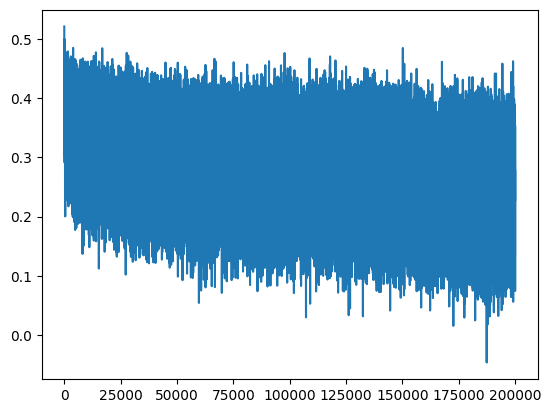

In [42]:
plt.plot(lossi)

Plot above is very messy because the __batch sizes are too small__ not allowing the model to achieve a consistent loss. Averaging out multiple losses will show a more accurate performance graph

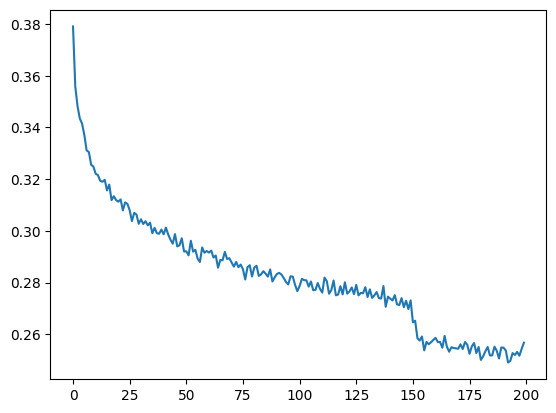

In [43]:
loss_batch = 1000
plt.plot(torch.tensor(lossi).view(-1, loss_batch).mean(1))

Model evaluation

In [44]:
for layer in model.layers:
  layer.training = False

In [45]:
# Evalute the loss
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690284252166748
val 1.993652582168579


In [51]:
# Make predictions
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)

    ix = torch.multinomial(probs, num_samples=1).item()

    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


## Performance Log

| Model | Context Length | Hidden Neurons | # Params | Train | Test |
| ---- | ---- | ---- | ---- | ---- | ---- |
| Original | 3 | 200 | 12,000 | 2.058 | 2.107 |
| Increase Context | 8 | 200 | 22,097 | 1.922 | 2.031
| Flat -> Hierarchical | 8 | 68 | 22,397 | 1.941 | 2.029
| Bugfix in BatchNorm | 8 | 68 | 22,397 | 1.911 | 2.021
| Increasing embeddings and hidden neurons | 24 | 128 | 76,579 | 1.769 | 1.993

Most of the time will be spent massaging the shapes in Jupyter notebook before productionising in python and created experiments

In [46]:
%watermark

Last updated: 2025-11-05T15:52:32.632098+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

